<a href="https://colab.research.google.com/github/sowad748/Data-Mining-Assignments-/blob/main/Assignment_5_Image_data_shahida_%26_sowad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**🔢 PART 1: Image Data — MNIST**

**🔹 Task 1 – Load and Prepare Data**

In [ ]:
import numpy as np
import struct
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
from collections import Counter

uploaded = files.upload()

# Load image and label functions
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows * cols) / 255.0

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        return np.frombuffer(f.read(), dtype=np.uint8)

# Load data
X = load_mnist_images('t10k-images.idx3-ubyte')
try:
    y = load_mnist_labels('t10k-labels-idx1-ubyte')
except FileNotFoundError:
    y = None

Saving t10k-images.idx3-ubyte to t10k-images (3).idx3-ubyte


**🔹 Task  2 – Apply KMeans Clustering (k=10)**

In [ ]:
# KMeans Clustering
k = 10
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

**🔹 Task 3 – Visualize Cluster Centroids**

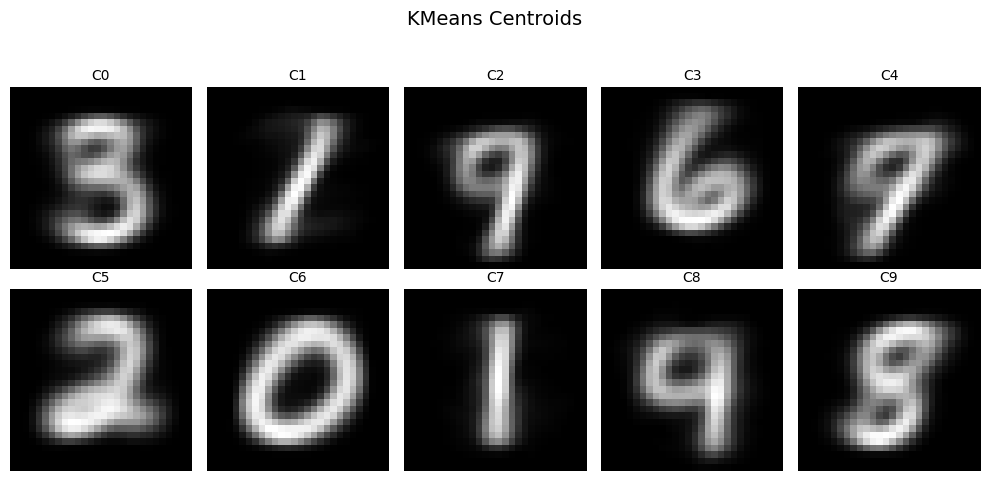

In [ ]:

# Centroid Visualization
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(centroids[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"C{i}", fontsize=10)
plt.suptitle("KMeans Centroids", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


**🔹 Task 4 – Visualize Clustering Result Using t-SNE (3D)**

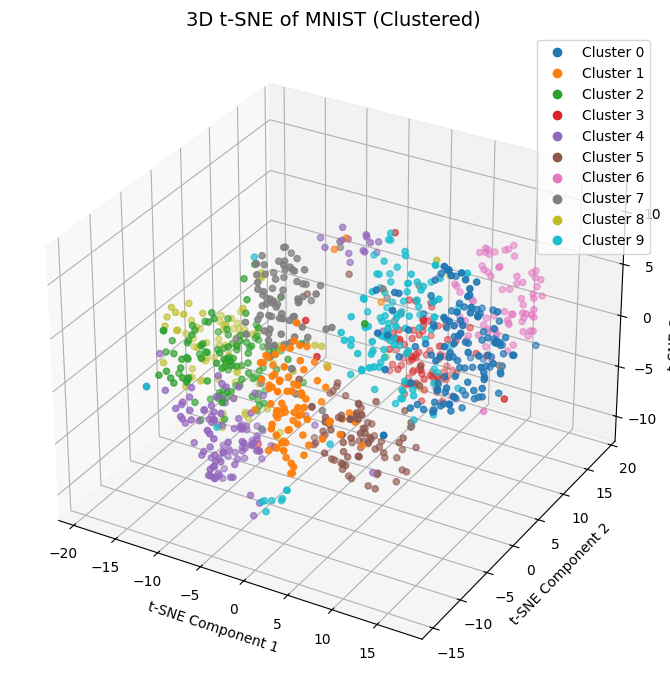

In [ ]:
# 3D TSNE Visualization
sample_idx = np.random.choice(len(X), 1000, replace=False)
X_sample = X[sample_idx]
y_sample = labels[sample_idx]
X_tsne = TSNE(n_components=3, random_state=42, perplexity=30).fit_transform(X_sample)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
                     c=y_sample, cmap='tab10', s=20)

ax.set_title("3D t-SNE of MNIST (Clustered)", fontsize=14)
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")

# Better legend
handles, _ = scatter.legend_elements()
legend_labels = [f"Cluster {i}" for i in np.unique(y_sample)]
ax.legend(handles, legend_labels, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


**🔹 Task 5 – Internal Validation (J-score, Davies-Bouldin Index, Dunn Index)**

In [ ]:
# ---------- Internal Validation ----------

# Optimized Euclidean Distance Calculation
def euclidean_squared(X, centroids):
    return np.min(np.sum((X[:, np.newaxis] - centroids) ** 2, axis=2), axis=1)

# J-Score Calculation
def j_score(X, centroids, labels):
    N = len(X)
    min_distances = euclidean_squared(X, centroids)
    return np.mean(min_distances)

# Davies-Bouldin Index
def davies_bouldin_index(X, labels):
    unique = np.unique(labels)
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique])
    S = np.array([np.mean(np.linalg.norm(X[labels == label] - centroids[i], axis=1)) for i, label in enumerate(unique)])
    db_index = 0
    for i in range(len(unique)):
        max_ratio = 0
        for j in range(len(unique)):
            if i != j:
                Mij = np.linalg.norm(centroids[i] - centroids[j])
                Rij = (S[i] + S[j]) / Mij
                max_ratio = max(max_ratio, Rij)
        db_index += max_ratio
    return db_index / len(unique)

# Dunn Index
def dunn_index(X, labels):
    unique = np.unique(labels)
    intra = []
    inter = []

    for i in unique:
        cluster_points = X[labels == i]
        max_dist = 0
        for a in range(len(cluster_points)):
            for b in range(a + 1, len(cluster_points)):
                dist = np.linalg.norm(cluster_points[a] - cluster_points[b])
                max_dist = max(max_dist, dist)
        intra.append(max_dist)

    for i in unique:
        for j in unique:
            if i >= j:
                continue
            cluster_i = X[labels == i]
            cluster_j = X[labels == j]
            min_dist = np.inf
            for p1 in cluster_i:
                for p2 in cluster_j:
                    dist = np.linalg.norm(p1 - p2)
                    min_dist = min(min_dist, dist)
            inter.append(min_dist)

    return np.min(inter) / np.max(intra)

# ---------- External Validation ----------

# Purity
def purity_score(y_true, y_pred):
    clusters = np.unique(y_pred)
    total = 0
    for c in clusters:
        labels = y_true[y_pred == c]
        if len(labels) == 0:
            continue
        total += Counter(labels).most_common(1)[0][1]
    return total / len(y_true)

# Rand Index
def rand_index(y_true, y_pred):
    tp_fp = 0
    tp = 0
    n = len(y_true)
    for i in range(n):
        for j in range(i + 1, n):
            same_true = y_true[i] == y_true[j]
            same_pred = y_pred[i] == y_pred[j]
            if same_true and same_pred:
                tp += 1
            if same_true or same_pred:
                tp_fp += 1
    return tp / tp_fp if tp_fp > 0 else 0

**🔹 Task 6 – Run Evaluation with External Validation Metrics**

In [ ]:
# ---------- Evaluation Runner ----------

def evaluate_clustering(X, labels, y_true=None):
    unique = np.unique(labels)
    centroids = np.array([X[labels == k].mean(axis=0) for k in unique])

    print("\n--- Internal Validation ---")
    j_score_val = j_score(X, centroids, labels)
    dbi = davies_bouldin_index(X, labels)
    dunn = dunn_index(X, labels)
    print(f"1. J (Avg. Min Distance to Centroids): {j_score_val:.4f}")
    print(f"2. Davies-Bouldin Index: {dbi:.4f}")
    print(f"3. Dunn Index: {dunn:.4f}")

    if y_true is not None:
        print("\n--- External Validation ---")
        purity = purity_score(y_true, labels)
        ri = rand_index(y_true, labels)
        print(f"4. Purity: {purity:.4f}")
        print(f"5. Rand Index: {ri:.4f}")
    else:
        print("\nExternal labels not provided. Skipping external validation.")

# Run Evaluation
evaluate_clustering(X_sample, labels[sample_idx], y_true=y_sample)


--- Internal Validation ---
1. J (Avg. Min Distance to Centroids): 38.1486
2. Davies-Bouldin Index: 2.7569
3. Dunn Index: 0.1021

--- External Validation ---
4. Purity: 1.0000
5. Rand Index: 1.0000
